#### Interactive Kymograph Code Draft

Xref: Journal/12_26_18/Interactive_Kymograph_Draft_no_scaling.ipynb

Goal: In this notebook, I will finalize the interactive kymograph code I wrote in `Interactive_Kymograph_v1.ipynb` This is a copy of `Interactive_Kymograph_Draft_no_scaling.ipynb`

This code should have the following features:

- seamless parameter tuning with visual outputs
- chunking of the analysis process into steps
- representative results from across the dataset
- global qc stats?

I should also use this code as an oppertunity to try out new things for the main (hdf5 using) codebase.

#### NOTE:

Modifying this code haphazardly is getting a bit unwieldy. Try to write down a game plan for the final drafting of the interactive kymograph, given what I have learned about the implementation. In addition, review the structure of this and the original kymograph code for restructuring/simplification. Finally, move on to the extraction code.

**THIS KYMOGRAPH CODE MUST BE DEPLOYABLE BY 1/4**

### PLAN TO GET THIS DONE

 - (1/2) Implement this structure and finish interactive code (including comments).
 - (1/3) Try to eleminate redundancy in codebase with global handlers for main code differences between interactive and
 server code...
 - (1/3) Revisit original code and implement structural simplification (i.e. distinct stopping points)
 - (1/3) Devise and implement library structure for the hdf5 conversion and kymograph code
 - (1/4) Finishing touches on library and start working on segmentation code.
 - (1/5) Write down structure of segmentation code (try to keep schematically similar to kymo code)
 - (?) Try to figure out if the read/write overhead is causing major problems...eliminate unnecessary I/O
 - (?) Play around with the dask way of chunking (in bookmarks) (don't do this until kymo interactive is done, but before seg)

In [1]:
from ipywidgets import interact, interactive, fixed, interact_manual, FloatSlider, IntSlider
import ipywidgets as widgets
import matplotlib
import warnings
matplotlib.rcParams['figure.figsize'] = [20, 10]
warnings.filterwarnings(action='once')

In [2]:
import interactive
from interactive import *

/home/de64/anaconda3/envs/mothermachine/lib/python3.6/site-packages/skimage/__init__.py:71: ResourceWarning: unclosed file <_io.TextIOWrapper name='/home/de64/anaconda3/envs/mothermachine/lib/python3.6/site-packages/pytest.py' mode='r' encoding='utf-8'>
  imp.find_module('pytest')
/home/de64/anaconda3/envs/mothermachine/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/home/de64/anaconda3/envs/mothermachine/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/home/de64/anaconda3/envs/mothermachine/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [3]:
input_path_prefix = '/n/groups/paulsson/Daniel/Image_analysis_pipeline/tiff_extraction/test_out_4/fov_'
kymo = interactive.kymograph_interactive(input_path_prefix,["channel_BF","channel_RFP"],270,20,30,[64,12,32,45],t_subsample_step=5)

In [4]:
imported_array_list = kymo.map_to_fovs(kymo.import_hdf5)
# imported_array_list = kymo.import_hdf5_list(fov_list,2)

In [7]:
matplotlib.rcParams['figure.figsize'] = [20, 10]
interact_manual(kymo.preview_y_precentiles, imported_array_list=fixed(imported_array_list),y_percentile=IntSlider(value=85, min=0, max=100, step=1),\
         smoothing_kernel_y_dim_0=IntSlider(value=9, min=0, max=20, step=1), smoothing_kernel_y_dim_1=IntSlider(value=3, min=0, max=10, step=1),\
               triangle_nbins=IntSlider(value=50, min=10, max=200, step=10),triangle_scaling=FloatSlider(value=1., min=0., max=2., step=0.05));

interactive(children=(IntSlider(value=85, description='y_percentile'), IntSlider(value=9, description='smoothi…

In [8]:
y_percentiles_smoothed_list = kymo.map_to_fovs(kymo.get_smoothed_y_percentiles,imported_array_list,85,(9,3))

In [9]:
interact_manual(kymo.preview_y_crop,y_percentiles_smoothed_list=fixed(y_percentiles_smoothed_list),\
                imported_array_list=fixed(imported_array_list),\
                y_time_percentile=IntSlider(value=85, min=0, max=100, step=1),\
                triangle_nbins=IntSlider(value=50, min=10, max=200, step=10),\
                triangle_scaling=FloatSlider(value=1., min=0., max=2., step=0.01),\
                y_min_edge_dist=IntSlider(value=50, min=10, max=200, step=10),\
                padding_y=IntSlider(value=20, min=0, max=100, step=1),\
                trench_len_y=IntSlider(value=270, min=0, max=1000, step=10),
               vertical_spacing=FloatSlider(value=0.9, min=0., max=2., step=0.01))

interactive(children=(IntSlider(value=50, description='triangle_nbins', max=200, min=10, step=10), FloatSlider…

<function ipywidgets.widgets.interaction._InteractFactory.__call__.<locals>.<lambda>(*args, **kwargs)>

In [10]:
trench_edges_y_lists = kymo.map_to_fovs(kymo.get_trench_edges_y,y_percentiles_smoothed_list,50,1.1,min_edge_dist=50)
row_num_list = kymo.map_to_fovs(kymo.get_row_numbers,trench_edges_y_lists)
cropped_in_y_list = kymo.map_to_fovs(kymo.crop_y,trench_edges_y_lists,row_num_list,imported_array_list,20,270,top_orientation=0)

In [11]:
interact_manual(kymo.preview_x_percentiles, cropped_in_y_list=fixed(cropped_in_y_list),t=IntSlider(value=0, min=0, max=cropped_in_y_list[0].shape[4]-1, step=1),\
                x_percentile=IntSlider(value=85, min=0, max=100, step=1),background_kernel_x=IntSlider(value=301, min=1, max=601, step=50), smoothing_kernel_x=IntSlider(value=9, min=1, max=31, step=2),\
               otsu_nbins=IntSlider(value=50, min=10, max=200, step=10),otsu_scaling=FloatSlider(value=1., min=0., max=2., step=0.01),\
               vertical_spacing=FloatSlider(value=0.9, min=0., max=2., step=0.01));

interactive(children=(IntSlider(value=0, description='t', max=4), IntSlider(value=85, description='x_percentil…

In [12]:
smoothed_x_percentiles_list = kymo.map_to_fovs(kymo.get_smoothed_x_percentiles,cropped_in_y_list,85,(301,1),(9,1))

In [13]:
interact_manual(kymo.preview_midpoints,smoothed_x_percentiles_list=fixed(smoothed_x_percentiles_list),\
                otsu_nbins=IntSlider(value=50, min=10, max=200, step=10),
                otsu_scaling=FloatSlider(value=1., min=0., max=2., step=0.01),\
               vertical_spacing=FloatSlider(value=0.8, min=0., max=2., step=0.01))

interactive(children=(IntSlider(value=50, description='otsu_nbins', max=200, min=10, step=10), FloatSlider(val…

<function ipywidgets.widgets.interaction._InteractFactory.__call__.<locals>.<lambda>(*args, **kwargs)>

In [14]:
all_midpoints_list = kymo.map_to_fovs(kymo.get_all_midpoints,smoothed_x_percentiles_list,50,1.)
x_drift_list = kymo.map_to_fovs(kymo.get_x_drift,all_midpoints_list)

In [15]:
matplotlib.rcParams['figure.figsize'] = [20, 10]
interact_manual(kymo.preview_kymographs,cropped_in_y_list=fixed(cropped_in_y_list),all_midpoints_list=fixed(all_midpoints_list),\
                x_drift_list=fixed(x_drift_list),trench_width_x=IntSlider(value=30, min=10, max=50, step=1),
               vertical_spacing=FloatSlider(value=0.8, min=0., max=2., step=0.01))

interactive(children=(IntSlider(value=30, description='trench_width_x', max=50, min=10), FloatSlider(value=0.8…

<function ipywidgets.widgets.interaction._InteractFactory.__call__.<locals>.<lambda>(*args, **kwargs)>

In [11]:
cropped_in_x_list = kymo.map_to_fovs(kymo.get_crop_in_x,cropped_in_y_list,all_midpoints_list,x_drift_list,30)

#### Note

 - Would it be worth converting the image to an 8 byte encoding for thresholding purposes?

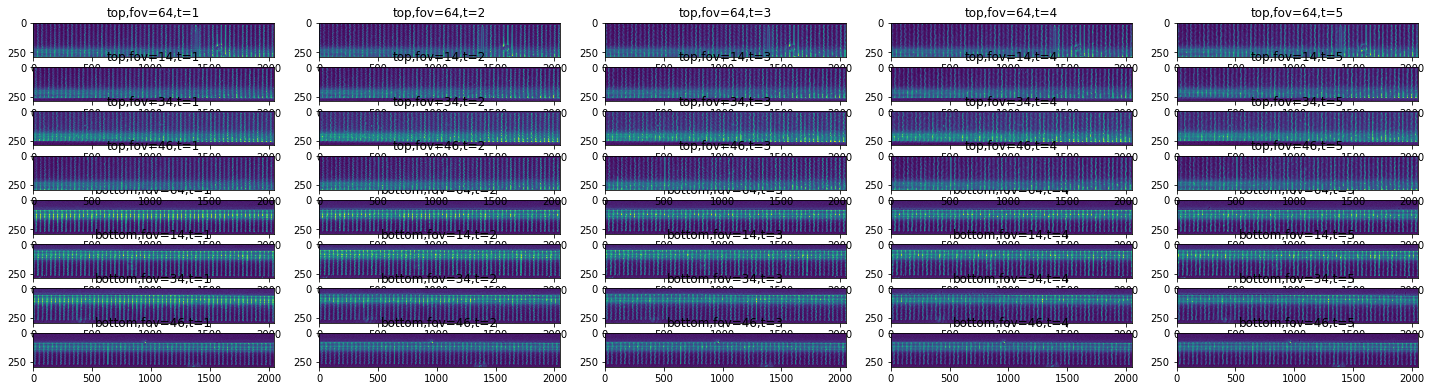

Timer unit: 1e-06 s

Total time: 4.32805 s
File: <ipython-input-4-1ebe84035521>
Function: import_hdf5 at line 173

Line #      Hits         Time  Per Hit   % Time  Line Contents
   173                                               def import_hdf5(self,hdf5_handle,t_dim_in):
   174                                                   """Stripped down version of 'self.chunk_t' that performs initial import of the hdf5 file to be
   175                                                   processed. Simply converts the input hdf5 file's "channel" datasets into the first dimension
   176                                                   of the array, ordered as specified by 'self.all_channels'
   177                                                   
   178                                                   Args:
   179                                                       t_dim_in (int): Specifies the time axis of the input array.
   180                                                       t_dim

In [8]:
%load_ext line_profiler
%lprun -f kymo.import_hdf5 kymo.preview_y_crop([64,14,34,46])

Seems like the limiting factor is by far the initial read in, so it doesn't seem that necessary to use the 8 bit encoding / resizing unless it is done in the primary kymograph code. The pros and cons of including it there are:

#### Pros
 - speedup on all computational operations
 - major speedup on intermediate read/write operations during processing
 
#### Cons
 - computational speedup pretty small
 - would need to compile information about places to crop prior to a final step in which
 cropping actually occurs on the original image data. This is a major restructuring....
 
#### outcome

Just keep this in mind for future features, but for now don't implement. Take interactive mode as is without resizing....

### MAJOR NOTE FOR SEGMENTATION CODE

The conversion to bits can be currupted by outlier signal, possibly from fringing at the end of trenches.

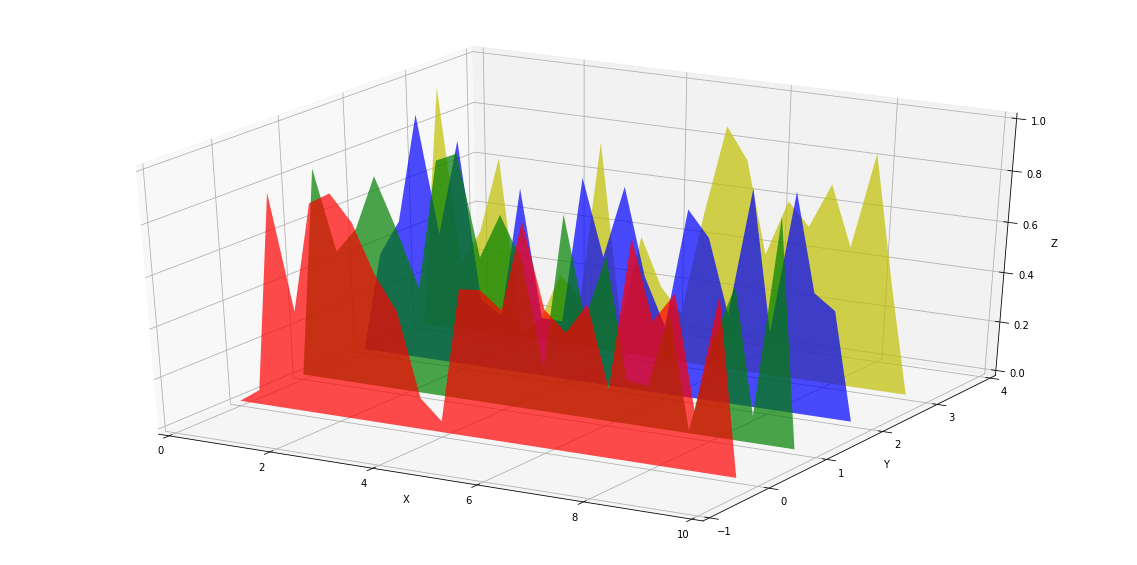

In [224]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.collections import PolyCollection
from matplotlib.colors import colorConverter
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure()
ax = fig.gca(projection='3d')

cc = lambda arg: colorConverter.to_rgba(arg, alpha=0.6)

xs = np.arange(0, 10, 0.4)
verts = []
zs = [0.0, 1.0, 2.0, 3.0]
for z in zs:
    ys = np.random.rand(len(xs))
    ys[0], ys[-1] = 0, 0
    verts.append(list(zip(xs, ys)))

poly = PolyCollection(verts, facecolors = [cc('r'), cc('g'), cc('b'),
                                           cc('y')])
poly.set_alpha(0.7)
ax.add_collection3d(poly, zs=zs, zdir='y')

ax.set_xlabel('X')
ax.set_xlim3d(0, 10)
ax.set_ylabel('Y')
ax.set_ylim3d(-1, 4)
ax.set_zlabel('Z')
ax.set_zlim3d(0, 1)

plt.show()

